# SUPERVISED LEARNING - Linear Regression Model
Linear regression is a quite popular statistical modeling technique as it is intuitive to understand its concept by showing relationship between attributes.  In spite of its simple concept, the relationship should be carefully considered as it does not necessarily show causality, but rather correlation.  

## Data Load & Simple Visualization

### To load the data:

1. Load the your local file into your notebook. Click the **Find and Add Data** icon on the notebook action bar. Drop the file into the box or browse to select the file. The file is loaded to your object storage and appears in the Data Assets section of the project. For more information, see <a href="https://datascience.ibm.com/docs/content/analyze-data/load-and-access-data.html" target="_blank" rel="noopener noreferrer">Load and access data</a>.
1. click in the next code cell and select **Insert to code > pandas DataFrame** under the file name.

For this exercise, the above steps were done in advance, and a csv file has been put in this notebook's working directory


In [1]:
from io import StringIO
import requests
import json
import pandas as pd

# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.

def get_object_storage_file_with_credentials_fcf1c90868844bc1ab7d4fffe6063140(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_cf2f28cf1cf37485c31a0c2d2443463e000ad9b0','domain': {'id': '20b49a5877434f9486aa2a1d2fcdd21c'},
            'password': 'tVP(ZWG8k9J._ZhB'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

df = pd.read_csv(get_object_storage_file_with_credentials_fcf1c90868844bc1ab7d4fffe6063140('MachineLearningShowcase', 'CRPMT_SAMPLE.csv'))
df.to_csv('CRPMT_SAMPLE.csv', index = False)

df.head()
#df.describe()

,﻿ACCT_NO,PROD,CURR_BAL,TENURE,CUST_INC,CUST_AGE,PMT_DUE,NO_DM_CNT,WRITE_OFF_IND,FICO_SCR
0,1291,1.REG,755.16,3.0,44212,46,60.41,5,1,651
1,1292,1.REG,276.61,0.7,86249,34,22.13,10,0,702
2,1293,2.GOLD,424.70,0.1,79474,45,21.23,22,0,753
3,1294,3.PLAT,11683.23,10.8,81198,58,584.16,22,0,763
4,1295,1.REG,246.34,5.5,63502,35,19.71,11,1,590


## Attributes in the sample file 

> this is a hypothetical sample file from a credit card company, in which a few attributes are mocked up for the various aspects of credit/payment business such as risk management, contact strategy and CRM

1. ACCT_NO: Account Number
1. PROD: Product Tier (1.REG: regular, 2.GOLD: gold and 3.PLAT: platinum cards)
1. CURR_BAL: Current balance on the account
1. TENURE: # of years since the account opened
1. CUST_AGE: Customer's age in years
1. PMT_DUE: Due amount on current billing cycle
1. NO_DM_CNT: # of Direct Mail Contacts for the last 2 years
1. WRITE_OFF_IND: Write-Off Indicator (0: Not written-off, 1: Written-Off)
1. FICO_SCR: Fair-Issac Score (a credit score that being calculated by US credit bureau such as Experian, Equifax or TransUnion)

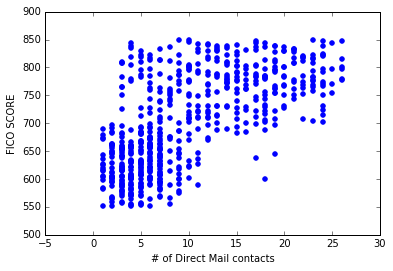

In [2]:
# import Matplotlib (scientific plotting library)
import matplotlib.pyplot as plt

# allow plots to appear within the notebook
%matplotlib inline

# Plot true values versus the predictions
plt.scatter(df.NO_DM_CNT, df.FICO_SCR, color="b")
plt.xlabel("# of Direct Mail contacts")
plt.ylabel("FICO SCORE")
plt.show()

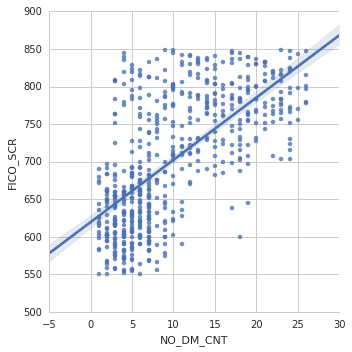

In [3]:
# Quick visualization of data relationships using seaborn visualization API
import seaborn as sns
sns.set_style('whitegrid')

# allow plots to appear within the notebook
%matplotlib inline

# Using seabron to create a linear fit
sns.lmplot('NO_DM_CNT','FICO_SCR', data = df)

## Are you getting a lot of junk mails?  

In this sample credit card data, there is a clear correlation between # of direct mail contacts and the high credit score customers.  This is a typical challenge for many credit-issuing companies to exhaust their marketing contacts for the highly credit-worthy customer population, while, in contrast, those highly profitable customer segments tend to get annoyed by this contact strategy, which usually lead into attrition or opt-out.

# LINEAR REGRESSION MODEL SETUP, TRAINING & ACCURACY CHECK

### Below is an illustrative example of finding out how write-off response may be correlated with predictor (feature) variables by training a multi-variate linear regression model

In [4]:
# as a regression model needs numerical attributes, let's convert PROD into a numerical format

df['PROD_NO'] = df.PROD.str.slice(0,1)
df.head(5)

,﻿ACCT_NO,PROD,CURR_BAL,TENURE,CUST_INC,CUST_AGE,PMT_DUE,NO_DM_CNT,WRITE_OFF_IND,FICO_SCR,PROD_NO
0,1291,1.REG,755.16,3.0,44212,46,60.41,5,1,651,1
1,1292,1.REG,276.61,0.7,86249,34,22.13,10,0,702,1
2,1293,2.GOLD,424.70,0.1,79474,45,21.23,22,0,753,2
3,1294,3.PLAT,11683.23,10.8,81198,58,584.16,22,0,763,3
4,1295,1.REG,246.34,5.5,63502,35,19.71,11,1,590,1


In [5]:
# IF YOU'D LIKE TO USE BUILT-IN SCIKIT-LEARN LABEL ENCODER, PLEASE RUN BELOW
# converting PROD to numerical (0: 1.REG, 1: 2.GOLD, 2: 3.PLAT)

#from sklearn.preprocessing import LabelEncoder

#lenc = LabelEncoder()
#lenc.fit(df['PROD'])

#df['PROD_NO'] = lenc.transform(df['PROD'])

#df.head(5)

In [6]:
# select a few numerical variables (predictors)

feature_cols = [          
    'CURR_BAL',                                               
    'TENURE',                       
    'CUST_INC',                      
    'CUST_AGE',                                
    'PMT_DUE',                                               
    'NO_DM_CNT',               
    'FICO_SCR',
    'PROD_NO'
]

In [7]:
# create a feature matrix 'X' 

X = df[feature_cols]
X.shape

#print (type(X))
# X.head()

(610, 8)

In [8]:
# create a response vector series 'y' 
y = df.WRITE_OFF_IND
y.shape
#y.dtypes

(610,)

In [9]:
# if you need to upgrade scikit learn
#!pip install --upgrade scikit-learn

In [10]:
# splitting in-sample training and test datasets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [11]:
# default split is 75% for training and 25% for testing; but chose above test size (test_size)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(427, 8)
(427,)
(183, 8)
(183,)


In [12]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [13]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

1.72703907024
[ -1.67137480e-04  -5.41420238e-03  -1.25093552e-06  -8.06300068e-04
   3.05661316e-03   7.71331257e-04  -2.63346867e-03   2.57614171e-01]


In [14]:
# pair the feature names with the coefficients
list(zip(feature_cols, linreg.coef_))

[('CURR_BAL', -0.00016713747957377358),
 ('TENURE', -0.0054142023809906122),
 ('CUST_INC', -1.2509355181841361e-06),
 ('CUST_AGE', -0.00080630006840221968),
 ('PMT_DUE', 0.0030566131568174879),
 ('NO_DM_CNT', 0.0007713312572409501),
 ('FICO_SCR', -0.0026334686715588458),
 ('PROD_NO', 0.257614170611423)]

In [15]:
# make predictions on the sample testing set (observations 20 thru 60)
y_pred = linreg.predict(X_test)
y_pred[20:60]

array([ 0.25716965,  0.15726984,  0.25336168,  0.10463159,  0.31275379,
        0.03441385, -0.14363823,  0.20787352,  0.2026911 ,  0.32504148,
        0.33482854,  0.24330737,  0.1226208 ,  0.17317343,  0.10260369,
        0.01012545,  0.01425215,  0.11230392,  0.19944144,  0.06771044,
        0.20324533,  0.20161377,  0.16110821,  0.0623051 ,  0.44837685,
        0.29356754,  0.14850782,  0.23160678,  0.03761416,  0.40753452,
       -0.15359744,  0.16036299,  0.19524691,  0.0694225 ,  0.0809665 ,
        0.20461945, -0.03642523,  0.38006493,  0.39894443,  0.15936492])

In [16]:
y_pred.shape

(183,)

## Three Accuracy Metrics:

* MAE is the easiest to understand, because it's the average error.
* MSE is more popular than MAE, because MSE "punishes" larger errors.
* RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.

In [17]:
# Computing metrics
# RMSE is a typical metrics in linear regression model to show the amount of variance between observations and best-fitted line

import numpy as np
from sklearn import metrics

print 'MAE is: {}'.format(metrics.mean_absolute_error(y_test, y_pred))
print 'MSE is: {}'.format (metrics.mean_squared_error(y_test, y_pred))
print 'RMSE is: {}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE is: 0.248687138133
MSE is: 0.117476468663
RMSE is: 0.342748404319


# Re-setting the threshold (changing the sensitivity)

In [18]:
# if you like to re-set the threshold; or changes the sensitivity for the target value (in this case, 0.25)
# in other words, we are setting 0.25 (or 25% probability of the customer is going to be written-off) as a threshold 

# round or classify numpy array of y_pred with a specific threshold

from sklearn.preprocessing import binarize
y_pred_cl = binarize([y_pred], 0.25)[0]
y_pred_cl

array([ 0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,
        0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
        0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
        0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [19]:
# compute the RMSE for new threshold
import numpy as np
from sklearn import metrics

print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_cl)))

0.449650744856


## SUMMARY
This illustrative python notebook shows how to get started with a simple machine learning utilizing linear regression modelling technique.  I hope you to see how easy to adopt IBM's Data Science Experience for your data analytics and modeling needs.  Please find overview and getting-started information in the Data Science Experience documentation: https://datascience.ibm.com/docs/content/getting-started/welcome-main.html. 
Learn about Jupyter notebooks, which are used throughout this scenario, in the Data Science Experience documentation: https://datascience.ibm.com/docs/content/analyze-data/notebooks-parent.html